# Feature engineering - Differentiations

This process aims to improve stationarity of the data.
The goal is to acheive the balance between stationarity and memory

## Setup

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [37]:
from pathlib import Path

# Configurable parts\
SYMBOL = "USDJPY"
MINUTES = 1
START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_RETURN.pkl"

## Load Data

In [38]:
df = pd.read_pickle(RESAMPLED_FILE_PATH)
df.head()

,timestamp,open,high,low,close,volume,spread
0,2024-01-01 22:00:00,140.8730,140.8730,140.8695,140.8720,7.800000e+09,0.0468
1,2024-01-01 22:01:00,140.8720,140.8720,140.8720,140.8720,1.400000e+09,0.0400
2,2024-01-01 22:02:00,140.8705,140.8705,140.8705,140.8705,1.400000e+09,0.0410
3,2024-01-01 22:03:00,140.8655,140.8655,140.8655,140.8655,1.400000e+09,0.0510
4,2024-01-01 22:05:00,140.8660,140.8660,140.8660,140.8660,2.100000e+09,0.0500


In [39]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.set_index('timestamp')

## Experiment

In this section, we are going to try out several different differecing techniques. 

And we are going to use Augmented Dickey–Fuller (ADF) test to determine whether the time series is stationary or not.

In [40]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [41]:
df_log = pd.DataFrame(np.log(df['close']),index=df.index)

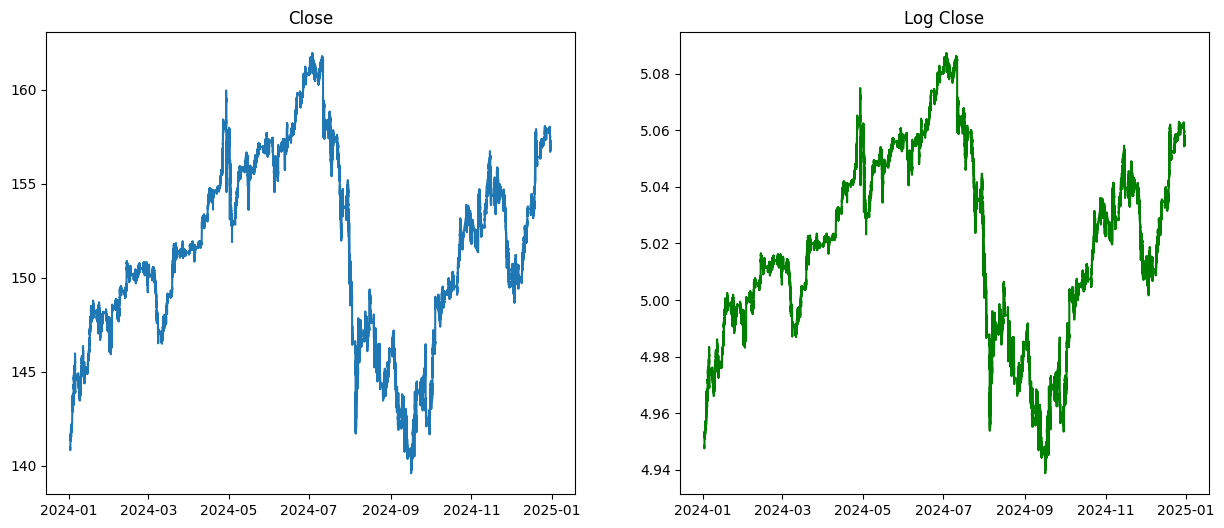

In [42]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(df['close'])
plt.title('Close')
plt.subplot(1,2,2)
plt.plot(df_log['close'],'g-')
plt.title('Log Close')
plt.show()

In [43]:
adftest=adfuller(df['close'])
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])
adftest=adfuller(df_log['close'])
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -2.076203
ADF p-value: 0.254190
ADF Statistic: -2.123685
ADF p-value: 0.235098


## Traditional Differentiation

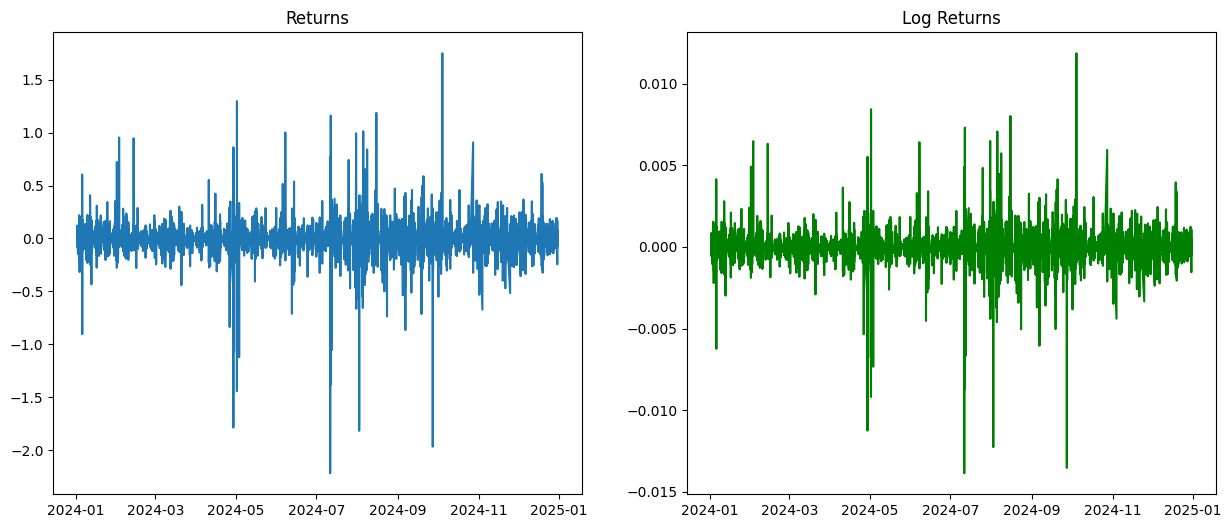

In [9]:
df['return'] = df['close'] - df['close'].shift(1)
df['log_return'] = df_log['close'] - df_log['close'].shift(1)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(df['return'])
plt.title('Returns')
plt.subplot(1,2,2)
plt.plot(df['log_return'],'g-')
plt.title('Log Returns')
plt.show()

In [10]:
adftest_ret=adfuller(df['return'].dropna())
print('ADF Statistic: %f' % adftest_ret[0])
print('ADF p-value: %f' % adftest_ret[1])
adftest_lret=adfuller(df['log_return'].dropna())
print('ADF Statistic: %f' % adftest_lret[0])
print('ADF p-value: %f' % adftest_lret[1])

ADF Statistic: -38.890599
ADF p-value: 0.000000
ADF Statistic: -38.908910
ADF p-value: 0.000000


可以看到取差分後 p-value 歸零 => 非常平穩。

取對數（log）前後之後，資料平穩程度並沒有明顯的變化

## Fractional Differentiation

In [11]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w
    
def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot(figsize=(15,6))
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()
    
def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients
    
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:] 

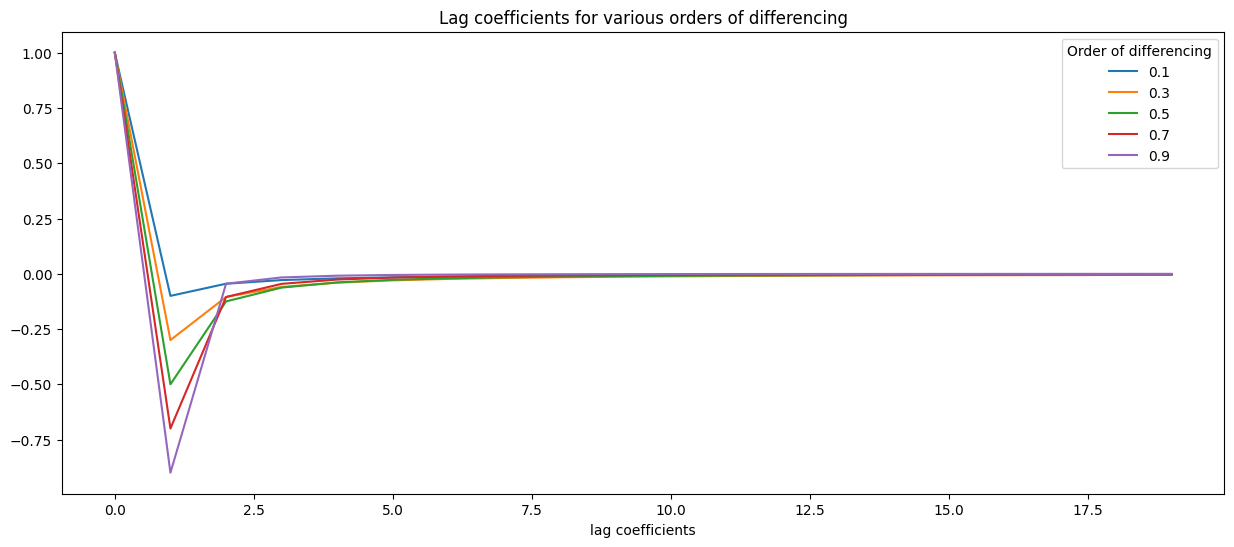

In [12]:
plotWeights([0.1,0.9],20,5)

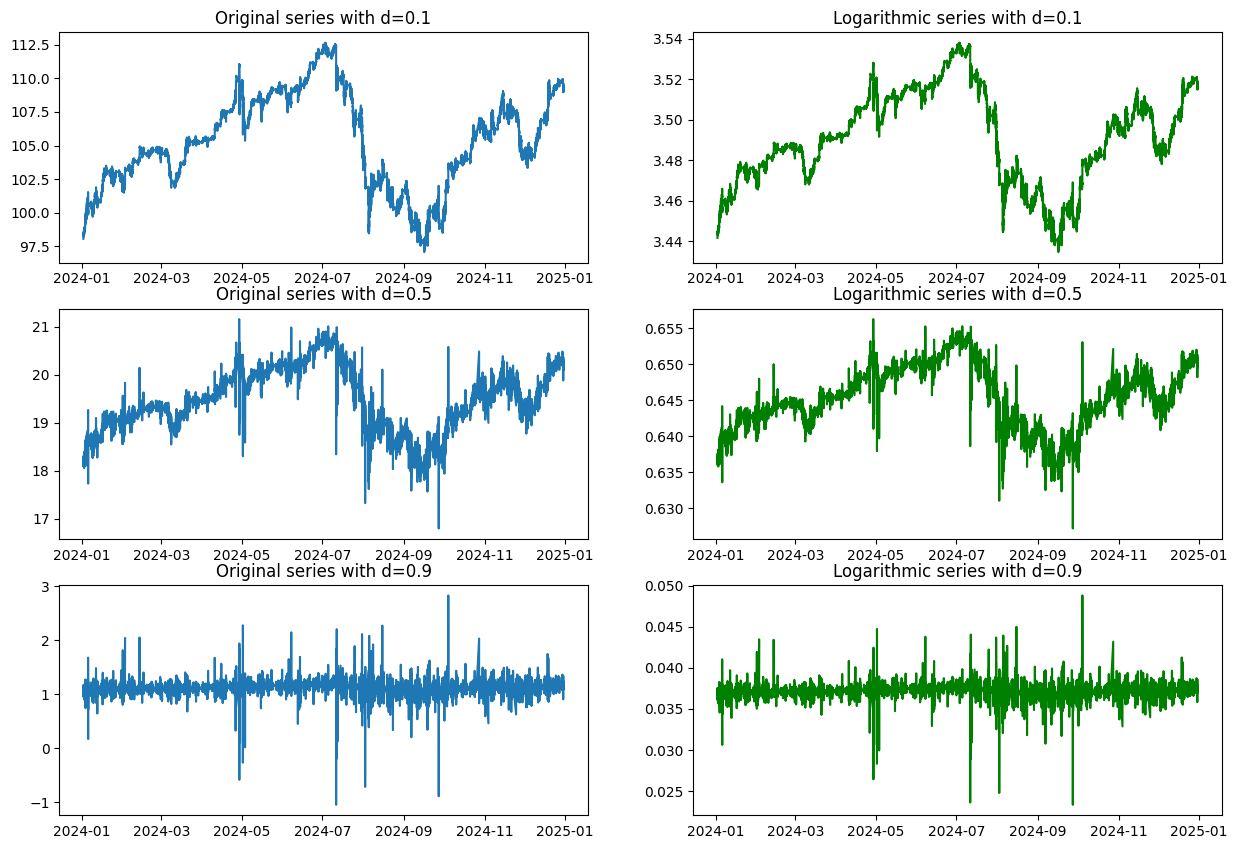

In [13]:
differences=[0.1, 0.5,0.9]
fig, axs = plt.subplots(len(differences),2,figsize=(15,9))
for i in range(0,len(differences)):
    axs[i,0].plot(ts_differencing(df['close'],differences[i],20))
    axs[i,0].set_title('Original series with d='+str(differences[i]))
    axs[i,1].plot(ts_differencing(df_log['close'],differences[i],20),'g-')
    axs[i,1].set_title('Logarithmic series with d='+str(differences[i]))
    plt.subplots_adjust(bottom=0.01) #increasing space between plots for aestethics

## Find Cutoff Automatically

In [14]:
def cutoff_find(order,cutoff,start_lags): #
    """
    order: our dearest d
    cutoff: 1e-5 for us
    start_lags: is an initial amount of lags in which the loop will start, this can be set to high values in order to speed up the algo
    """
    val=np.inf
    lags=start_lags
    while abs(val)>cutoff:
        w=getWeights(order, lags)
        val=w[len(w)-1]
        lags+=1
    return lags

def ts_differencing_tau(series, order, tau):
    # return the time series resulting from (fractional) differencing
    lag_cutoff=(cutoff_find(order,tau,1)) #finding lag cutoff with tau
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:] 

Visualize relationship between the ADF p-value and our fractional differencing order  𝑑

In [21]:
%%time
from tqdm import tqdm
possible_d=np.divide(range(1,100),100)
tau=1e-5
original_adf_stat_holder=[None]*len(possible_d)
log_adf_stat_holder=[None]*len(possible_d)

for i in tqdm(range(len(possible_d))):
    original_adf_stat_holder[i]=adfuller(ts_differencing_tau(df['close'],possible_d[i],tau))[1]
    log_adf_stat_holder[i]=adfuller(ts_differencing_tau(df_log['close'],possible_d[i],tau))[1]

100%|█████████████████████████████████████████████████| 99/99 [10:20<00:00,  6.27s/it]

CPU times: user 15min 45s, sys: 3min 36s, total: 19min 22s
Wall time: 10min 20s


Text(0.5, 1.0, 'ADF P-value by differencing order in the logarithmic series')

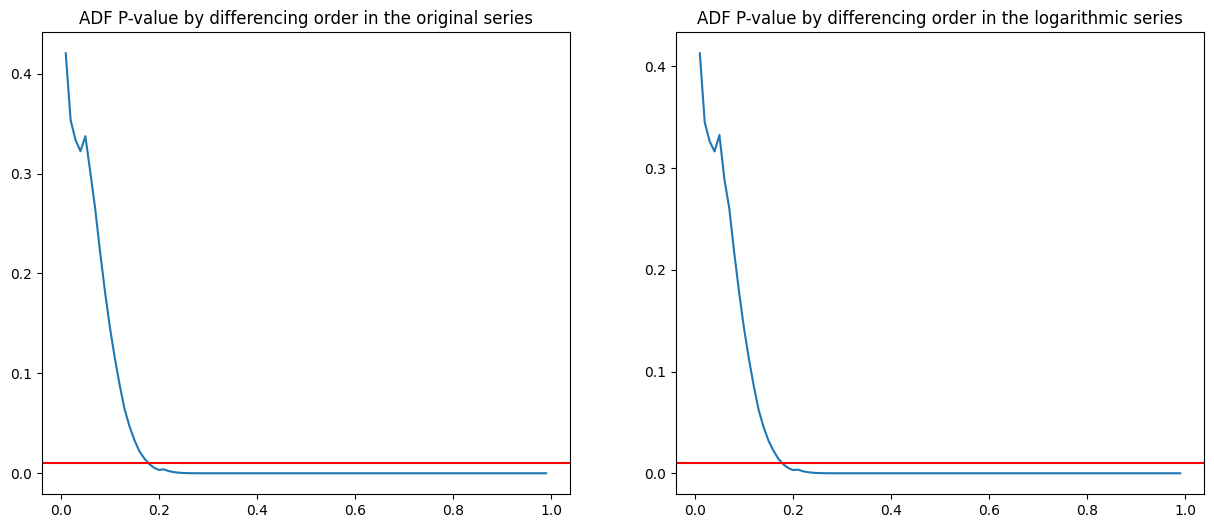

In [22]:
#now the plots of the ADF p-values
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].plot(possible_d,original_adf_stat_holder)
axs[0].axhline(y=0.01,color='r')
axs[0].set_title('ADF P-value by differencing order in the original series')
axs[1].plot(possible_d,log_adf_stat_holder)
axs[1].axhline(y=0.01,color='r')
axs[1].set_title('ADF P-value by differencing order in the logarithmic series')

In [25]:
def find_d(adf_stat, threshold):
    pvals = np.array(adf_stat, dtype=float)
    idx = np.where(pvals < threshold)[0]
    
    if idx.size > 0:
        # pick the first (lowest d) where it crosses
        best_idx = idx[0]
        best_d = possible_d[best_idx]
        return best_d
    else:
        return 0

In [26]:
d_original = find_d(original_adf_stat_holder, 0.01)
d_log = find_d(log_adf_stat_holder, 0.01)

print(f"The ideal d value for original price series is: {d_original}")
print(f"The ideal d value for logarithmic price series is: {d_log}")

The ideal d value for original price series is: 0.18
The ideal d value for logarithmic price series is: 0.18


從以上結果來看，其實只需要 0.34 階分差，就可以讓序列達到平穩，在這樣的情況下，沒有必要取到完整的階分差。
採用完整的階分差反而會導致序列過於平穩而失去長期記憶。
採用分數階分差，可以在保存長期記憶的狀態下，盡可能達到資料平穩。

In [56]:
df['fd_return'] = ts_differencing_tau(df['close'], d_original, 1e-5)
df['log_fd_return'] = ts_differencing_tau(df_log['close'], d_log, 1e-5)

In [70]:
df['return'] = df['close'] / df['close'].shift(1) - 1

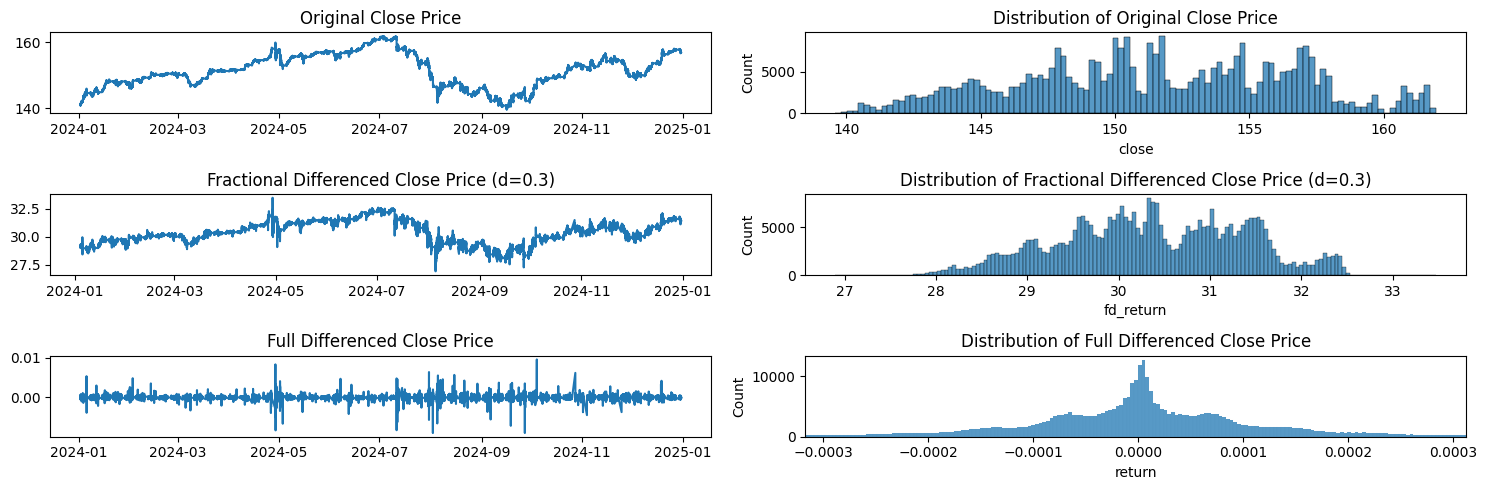

In [91]:
import seaborn as sns

fig, axs = plt.subplots(3,2,figsize=(15,5))
axs[0, 0].plot(df['close'])
axs[0, 0].set_title('Original Close Price')
sns.histplot(df['close'], ax=axs[0,1])
axs[0, 1].set_title('Distribution of Original Close Price')
axs[1, 0].plot(df['fd_return'])
axs[1, 0].set_title('Fractional Differenced Close Price (d=0.3)')
sns.histplot(df['fd_return'], ax=axs[1,1])
axs[1, 1].set_title('Distribution of Fractional Differenced Close Price (d=0.3)')


axs[2, 0].plot(df['return'])
axs[2, 0].set_title('Full Differenced Close Price')

low, high = df['return'].quantile([0.025, 0.975])
sns.histplot(df['return'], ax=axs[2,1])
axs[2, 1].set_title('Distribution of Full Differenced Close Price')
axs[2, 1].set_xlim(low, high)

# for i in range(0,len(differences)):
#     axs[i,0].plot(ts_differencing(df['close'],differences[i],20))
#     axs[i,0].set_title('Original series with d='+str(differences[i]))
#     axs[i,1].plot(ts_differencing(df_log['close'],differences[i],20),'g-')
#     axs[i,1].set_title('Logarithmic series with d='+str(differences[i]))
plt.tight_layout() #increasing space between plots for aestethics

<Axes: xlabel='timestamp'>

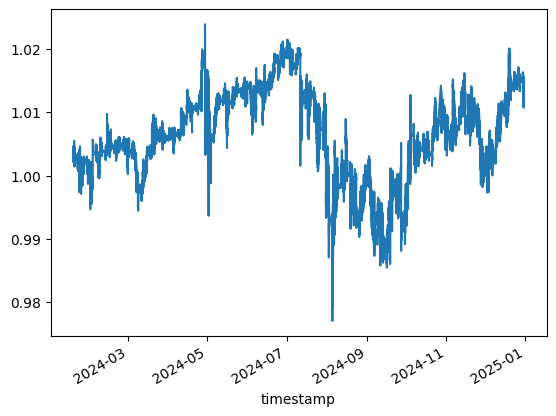

In [35]:
df['log_fd_return'].plot()

<Axes: >

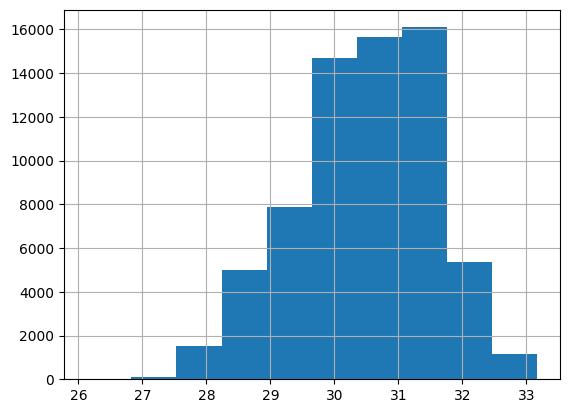

In [34]:
df['fd_return'].hist()

In [28]:
df.dropna(inplace=True)

In [29]:
df

,open,high,low,close,volume,spread,return,log_return,fd_return,log_fd_return
timestamp,,,,,,,,,,
2024-01-18 10:50:00,147.9190,147.9190,147.8760,147.8830,3.683790e+12,0.006395,-0.0365,-0.000247,29.867586,1.002743
2024-01-18 10:55:00,147.8825,147.8885,147.8520,147.8570,3.226040e+12,0.005720,-0.0260,-0.000176,29.844733,1.002588
2024-01-18 11:00:00,147.8565,147.8700,147.8325,147.8665,3.734520e+12,0.005756,0.0095,0.000064,29.859173,1.002686
2024-01-18 11:05:00,147.8660,147.9150,147.8650,147.9075,3.275530e+12,0.006301,0.0410,0.000277,29.900097,1.002962
2024-01-18 11:10:00,147.9105,147.9640,147.9095,147.9440,3.047220e+12,0.005838,0.0365,0.000247,29.929236,1.003159
...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:35:00,157.0160,157.0160,156.9610,157.0075,1.602750e+12,0.011005,-0.0110,-0.000070,31.458989,1.013126
2024-12-30 23:40:00,157.0075,157.0345,157.0050,157.0335,1.957770e+12,0.014153,0.0260,0.000166,31.485676,1.013296
2024-12-30 23:45:00,157.0330,157.0410,156.9830,156.9955,9.198600e+11,0.009822,-0.0380,-0.000242,31.442658,1.013022


In [30]:
df.to_pickle(PROCESSED_FILE_PATH)

In [ ]:
print(PROCESSED_FILE_PATH)